# Testing the embedding processsing methods
find_similar_qdrant, find_representative, leverage_OOD, find_mismatches

In [1]:
import numpy as np

from luxonis_ml.embeddings.qdrant_utils import *
from luxonis_ml.embeddings.embeddings_processing import *

import matplotlib.pyplot as plt
import cv2

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Start the Qdrant Docker container
start_docker_qdrant()

# Initialize the Qdrant client
qdrant_client = connect_to_qdrant()
create_collection(qdrant_client, collection_name="mnist3", vector_size=2048, distance=Distance.COSINE)


Container is already running.
Collection already exists


### Find representative images

In [3]:
ids = get_all_ids(qdrant_client, collection_name="mnist3")

In [4]:
# ids, embs, res = get_full_similarity_matrix(qdrant_client, collection_name="mnist3")

In [5]:
ids, embeddings = get_all_embeddings(qdrant_client, collection_name="mnist3")

In [6]:
similarity_matrix = calculate_similarity_matrix(embeddings)

In [7]:
desired_size = int(len(embeddings)*0.05)
# desired_size = 10
selected_image_indices = find_representative_kmedoids(similarity_matrix, desired_size)
# selected_image_indices = find_representative_greedy_qdrant(qdrant_client, desired_size, 0, "mnist3")

In [8]:
ids_sel = np.array(ids)[selected_image_indices].tolist()
payloads = get_payloads_from_ids(qdrant_client, ids_sel, collection_name="mnist3")

In [9]:
represent_imgs = [p['image_path'] for p in payloads]
len(represent_imgs)

317

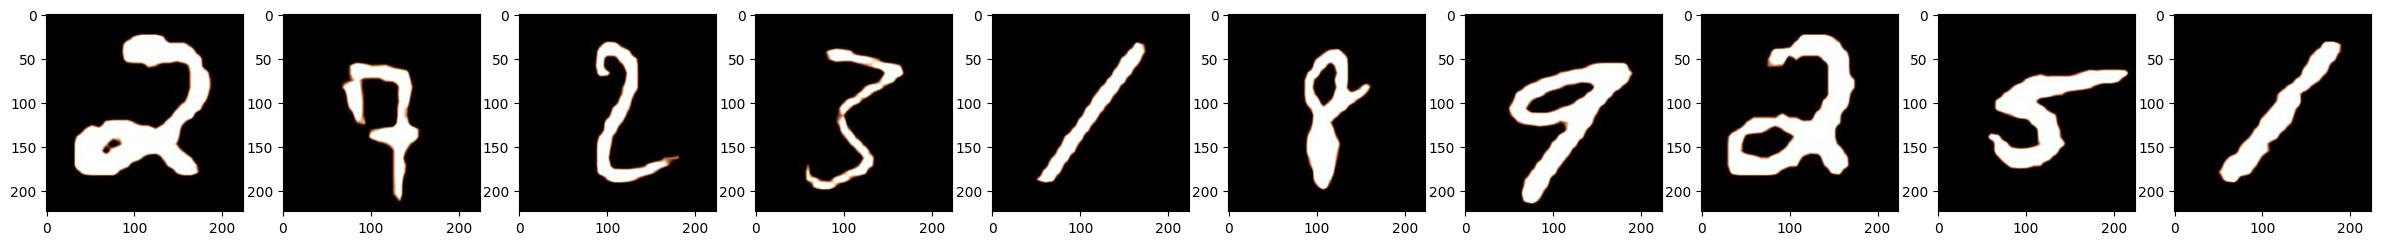

In [10]:
# set plt size 
plt.rcParams['figure.figsize'] = [30, 10]

for j in range(min(10,len(represent_imgs))):
    plt.subplot(1,10,j+1)
    img = cv2.imread(represent_imgs[j])
    plt.imshow(img)

plt.show()

### Out-of-distribution detection

In [11]:
idx = leverage_OOD(np.array(embeddings))

In [12]:
ids_sel = np.array(ids)[idx].tolist()
payloads = get_payloads_from_ids(qdrant_client, ids_sel, collection_name="mnist3")

In [13]:
outlier_imgs = [p['image_path'] for p in payloads]

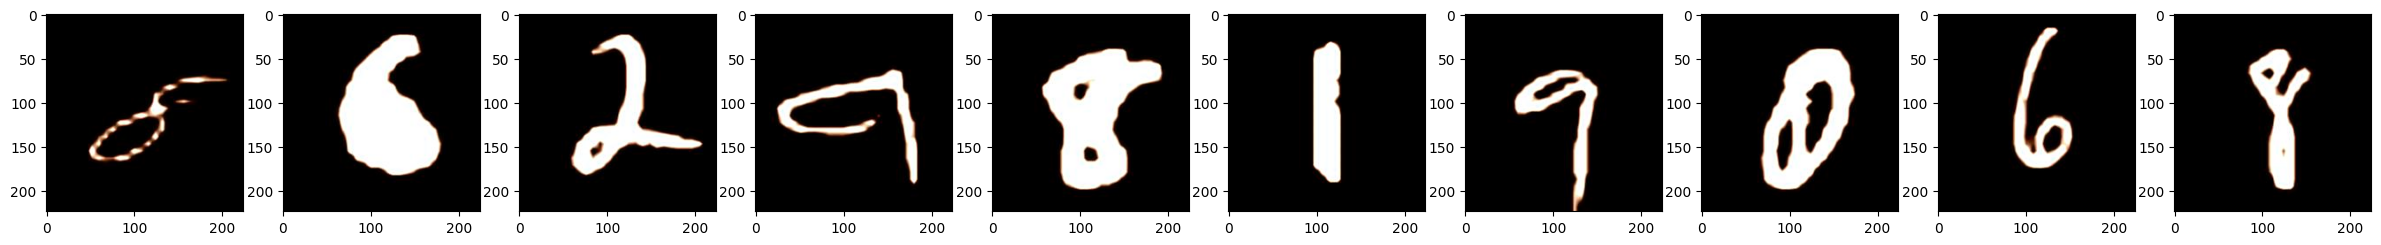

In [14]:
plt.rcParams['figure.figsize'] = [30, 10]

for j in range(min(10,len(outlier_imgs))):
    plt.subplot(1,10,j+1)
    img = cv2.imread(outlier_imgs[j])
    plt.imshow(img)

plt.show()

### Find similar images

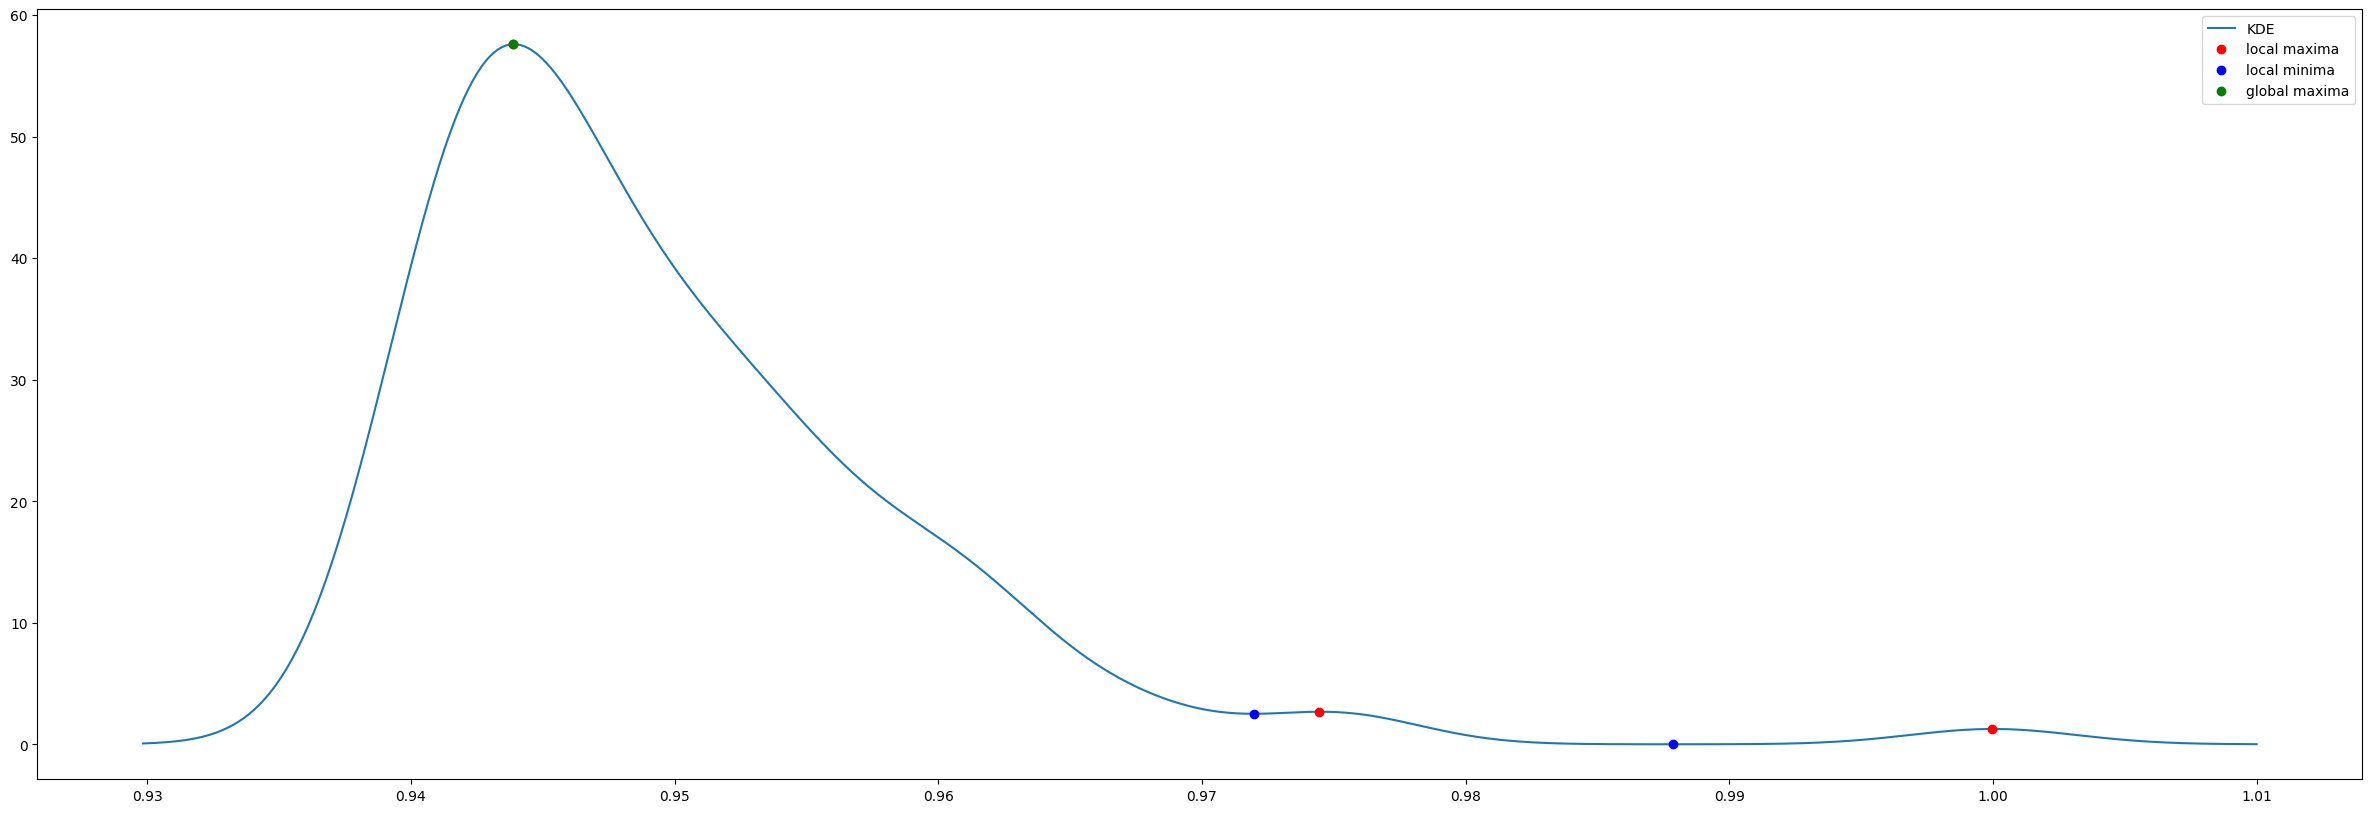

3 0.9878539782582583


In [15]:
i_sim, path_sim = find_similar_qdrant(ids[4], 
                                      qdrant_client, 
                                      k=100,
                                      collection_name="mnist3", 
                                      dataset="", 
                                      n=100, 
                                      method='first',
                                      k_method="kde_peaks",
                                      kde_bw="scott",
                                      plot=True)

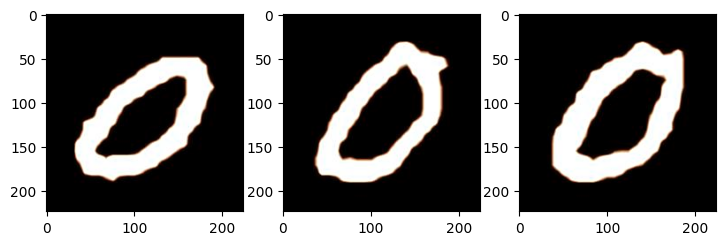

In [16]:
plt.rcParams['figure.figsize'] = [30, 10]

for j in range(min(10,len(path_sim))):
    plt.subplot(1,10,j+1)
    img = cv2.imread(path_sim[j])
    plt.imshow(img)

plt.show()

### Find mismatches

In [17]:
ids, embeddings = get_all_embeddings(qdrant_client, collection_name="mnist3")
payloads = get_payloads_from_ids(qdrant_client, ids, collection_name="mnist3")

In [18]:
X = np.array(embeddings)
y = np.array([p['class'] for p in payloads])

In [19]:
mis_ix, new_y = find_mismatches_centroids(X, y)

In [20]:
# find img paths for misclassified images
mis_img_paths = [payloads[i]['image_path'] for i in mis_ix]

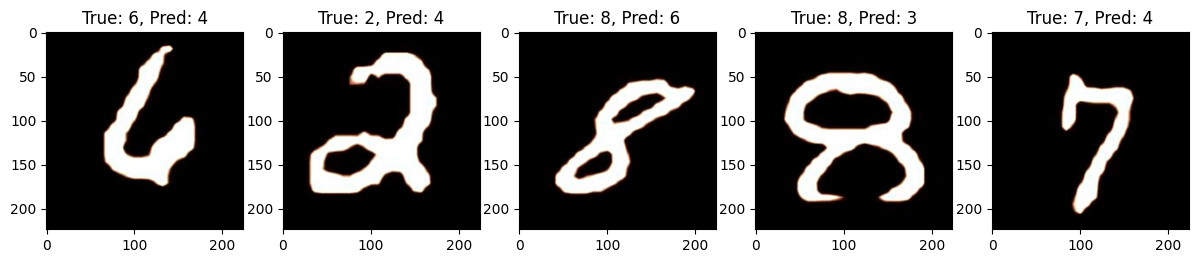

In [21]:
# plot
plt.rcParams['figure.figsize'] = [30, 10]

for j in range(min(5,len(mis_img_paths))):
    plt.subplot(1,10,j+1)
    img = cv2.imread(mis_img_paths[j])
    plt.title(f"True: {y[mis_ix[j]]}, Pred: {new_y[j]}")
    plt.imshow(img)

plt.show()